# PhenoCam - Extracting Image Statistics over a Region of Interest (ROI)

Here's an iPython notebook to demonstrate the code used in getting stats from an image and ROI mask pair.  Let's start by reading in an image and mask.  The routine processing code is written in python but we've compared similar processing in R, and MATLAB with comparable results.  

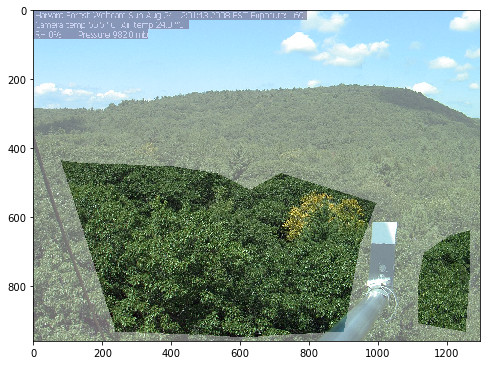

In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline

test_image = 'harvard_2008_08_24_120140.jpg'
test_mask = 'harvard_DB_0001_01.tif'

# read in mask image and convert to nparray
mask_img = Image.open(test_mask)
roimask = np.asarray(mask_img, dtype=np.bool8)

# read in canopy image
img = Image.open(test_image)
img.load()

# create an image with alpha mask
rev_mask_img = ImageOps.invert(mask_img)
alpha_data = rev_mask_img.getdata()
rev_mask_img.putdata(alpha_data,.4,150)
imga = img.copy()
fig = plt.figure(figsize=[8,8])
imga.putalpha(rev_mask_img)
plt.imshow(imga)

The quantity we use for phenological studies is the "green chromatic coordinate" or "gcc" value.  This is defined as:

$$ gcc = \frac{g_{mean}}{r_{mean} + g_{mean} + b_{mean}} $$

To further characterize the distribution of color over the ROi we also calculate the percentiles of the distributions of the digital number (DN) values for each color plane.  The correlations coefficients between the DN's of the different color planes are also calculated.  Here is the function used in standard processing routines.

In [2]:
def get_roi_stats(im, roimask):
    """
    Function to return a collection of stats for DN values for an image / mask pair.
    """
 
    # split into bands
    (im_r, im_g, im_b) = im.split()

    # create numpy arrays with bands
    r_array = np.asarray(im_r, dtype=np.int16)
    g_array = np.asarray(im_g, dtype=np.int16)
    b_array = np.asarray(im_b, dtype=np.int16)

    # try applying mask to red image ... if mask and image don't
    # have same size this will raise an exception.
    try:
        r_ma = np.ma.array(r_array,mask=roimask)
    except:
        errstr = "Error applying mask to image file.\n"
        sys.stderr.write(errstr)
        return None

    # make masked arrays for G,B
    g_ma = np.ma.array(g_array,mask=roimask)
    b_ma = np.ma.array(b_array,mask=roimask)

    # find mean, std
    r_vals = r_ma.compressed()
    r_mean = r_vals.mean()
    r_diff = np.float64(r_vals) - r_mean
    r_std = np.sqrt(np.dot(r_diff, r_diff)/r_vals.size)

    g_vals = g_ma.compressed()
    g_mean = g_vals.mean()
    g_diff = np.float64(g_vals) - g_mean
    g_std = np.sqrt(np.dot(g_diff, g_diff)/g_vals.size)
    
    b_vals = b_ma.compressed()
    b_mean = b_vals.mean()
    b_diff = np.float64(b_vals) - b_mean
    b_std = np.sqrt(np.dot(b_diff, b_diff)/b_vals.size)
    
    # calculate percentiles for each array
    r_pcts = np.percentile(r_vals, (5., 10., 25., 50., 75., 90., 95.))
    g_pcts = np.percentile(g_vals, (5., 10., 25., 50., 75., 90., 95.))
    b_pcts = np.percentile(b_vals, (5., 10., 25., 50., 75., 90., 95.))
    
    
    # calculate covariance 
    rg_cov = np.dot(r_diff, g_diff)/r_diff.size
    gb_cov = np.dot(g_diff, b_diff)/g_diff.size
    br_cov = np.dot(b_diff, r_diff)/b_diff.size
    
    # correlation coefficients
    RG_cor = rg_cov/(r_std * g_std)
    GB_cor = gb_cov/(g_std * b_std)
    BR_cor = br_cov/(b_std * r_std)
    
    # return list of values
    return [{'mean': r_mean, 
             'stdev': r_std, 
             'percentiles': r_pcts}, 
            {'mean': g_mean,
             'stdev': g_std, 
             'percentiles':g_pcts}, 
             {'mean': b_mean, 
              'stdev': b_std, 
              'percentiles': b_pcts}, 
            RG_cor, GB_cor, BR_cor]

In [3]:
# call stats function
stats = get_roi_stats(img, roimask)
stats

[{'mean': 62.556640022649944,
  'percentiles': array([ 10.,  17.,  32.,  57.,  86., 116., 136.]),
  'stdev': 39.89378239977369},
 {'mean': 83.98557582927606,
  'percentiles': array([ 24.,  32.,  51.,  80., 111., 141., 161.]),
  'stdev': 42.9818562214877},
 {'mean': 49.75276678143312,
  'percentiles': array([  2.,   9.,  23.,  44.,  70.,  97., 116.]),
  'stdev': 35.644726697302914},
 0.9763780243197164,
 0.942886118518965,
 0.9420226381040935]

To get a better idea of what these numbers mean let's repeat the above without using a function.  That way we can examine some of the intermediate steps.  In particular it would be nice to examine the distribution of DN values over the ROI for each of the color planes.

In [4]:
# split into bands
(im_r, im_g, im_b) = img.split()

# create numpy arrays with bands
r_array = np.asarray(im_r, dtype=np.float64)
g_array = np.asarray(im_g, dtype=np.float64)
b_array = np.asarray(im_b, dtype=np.float64)
brt_array = r_array + g_array + b_array

# apply mask to brightness image 
brt_ma = np.ma.array(brt_array,mask=roimask)

# make masked arrays for R,G,B
g_ma = np.ma.array(g_array,mask=roimask)
r_ma = np.ma.array(r_array,mask=roimask)
b_ma = np.ma.array(b_array,mask=roimask)

Basically, all I've done so far is split the image into R,G and B components and created a ```numpy``` "masked array".  For simple stats, like ```mean```, used in the previous calculations we could just use masked array functions.  Here I'm going to grab the un-masked values and put them in 1-d arrays.  This also makes it easier to do the plotting.  

Number of pixels in image: 1244160
Number of masked pixels: 395586
62.556640022649944 39.893782399773684 57.0 1591.5138741604924 [ 10.  17.  32.  57.  86. 116. 136.]
83.98557582927606 42.98185622148774 80.0 1847.4399642446442 [ 24.  32.  51.  80. 111. 141. 161.]
49.75276678143312 35.64472669730293 44.0 1270.5465413254203 [  2.   9.  23.  44.  70.  97. 116.]


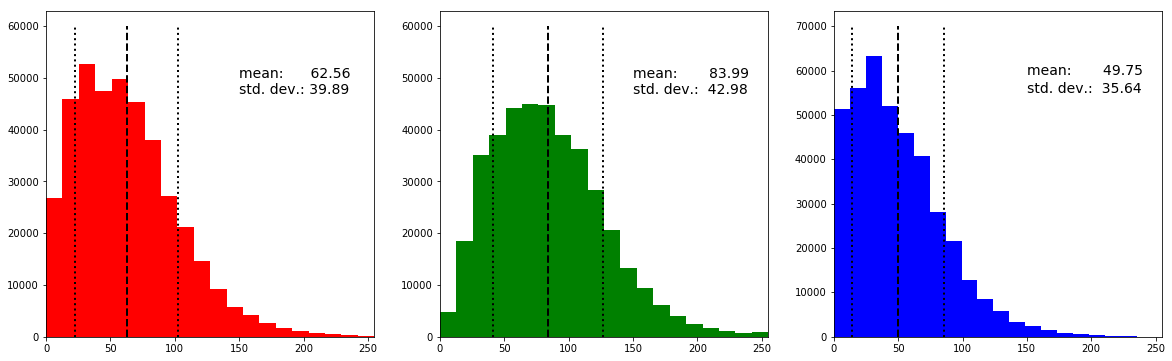

In [5]:
# first let's get percentiles for R, G and B
nvalues = g_ma.size
r_values = r_ma.compressed()
g_values = g_ma.compressed()
b_values = b_ma.compressed()

print "Number of pixels in image: {0}".format(nvalues)
print "Number of masked pixels: {0}".format(len(g_values))

# calculate mean, median and std-dev for R, G, B
r_mean = np.mean(r_values)
r_median = np.median(r_values)
r_var = np.var(r_values)
r_std = np.std(r_values)
g_mean = np.mean(g_values)
g_median = np.median(g_values)
g_var = np.var(g_values)
g_std = np.std(g_values)
b_mean = np.mean(b_values)
b_median = np.median(b_values)
b_var = np.var(b_values)
b_std = np.std(b_values)

# calculate percentiles for each array
r_percentiles = np.percentile(r_values, (5., 10., 25., 50., 75., 90., 95.))
g_percentiles = np.percentile(g_values, (5., 10., 25., 50., 75., 90., 95.))
b_percentiles = np.percentile(b_values, (5., 10., 25., 50., 75., 90., 95.))

# histogram the value for R, G, B
fig = plt.figure(figsize=[20,6])

r_95 = r_percentiles[-1]
r_low = r_mean - r_std
r_high = r_mean + r_std
plt.subplot(1,3,1)
plt.hist(r_values,20,color='r')
plt.plot([r_mean, r_mean], [0,60000], 'k--', lw=2)
plt.plot([r_low, r_low], [0,60000], 'k:', lw=2)
plt.plot([r_high, r_high], [0,60000], 'k:', lw=2 )
plt.text(150,50000,'mean:      {0:.2f}'.format(r_mean), size=14)
plt.text(150,47000,'std. dev.: {0:.2f}'.format(r_std), size=14)
plt.xlim([0,255])

g_95 = g_percentiles[-1]
g_low = g_mean - g_std
g_high = g_mean + g_std
plt.subplot(1,3,2)
plt.hist(g_values,20,color='g')
plt.plot([g_mean, g_mean], [0,60000], 'k--', lw=2)
plt.plot([g_low, g_low], [0,60000], 'k:', lw=2)
plt.plot([g_high, g_high], [0,60000], 'k:', lw=2 )
plt.text(150,50000,'mean:       {0:.2f}'.format(g_mean), size=14)
plt.text(150,47000,'std. dev.:  {0:.2f}'.format(g_std), size=14)
plt.xlim([0,255])

b_95 = b_percentiles[-1]
b_low = b_mean - b_std
b_high = b_mean + b_std
plt.subplot(1,3,3)
plt.hist(b_values,20,color='b')
plt.plot([b_mean, b_mean], [0,70000], 'k--', lw=2)
plt.plot([b_low, b_low], [0,70000], 'k:', lw=2)
plt.plot([b_high, b_high], [0,70000], 'k:', lw=2 )
plt.text(150,59000,'mean:       {0:.2f}'.format(b_mean), size=14)
plt.text(150,55000,'std. dev.:  {0:.2f}'.format(b_std), size=14)

plt.xlim([0,255])


print r_mean, r_std, r_median, r_var, r_percentiles
print g_mean, g_std, g_median, g_var, g_percentiles
print b_mean, b_std, b_median, b_var, b_percentiles

Visualizing the correlation coefficients is probably best done by showing a scatterplot of DN values for the pixels in the ROI.

rg_cov: 1674.20824143  rb_cov: 1339.56237599  gb_cov: 1444.57733303
rg_cor: 0.976380492507  rb_cor: 0.942025019445  gb_cor: 0.942888502042


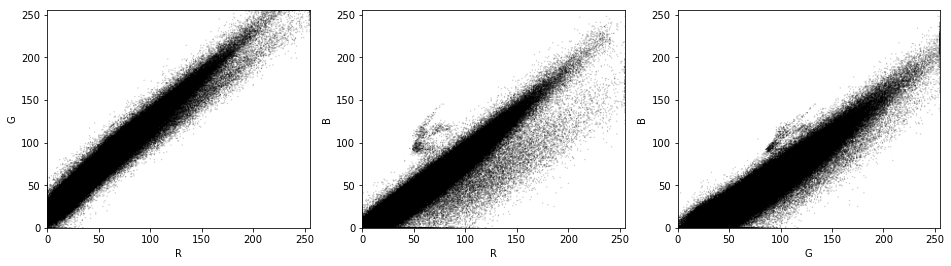

In [6]:
# calculate the covariance matrix between pairs (R,G), (R,B), (G,B)
rg_cov = np.cov(r_values, g_values)
rb_cov = np.cov(r_values, b_values)
gb_cov = np.cov(g_values, b_values)

fig = plt.figure(figsize=[16,4])
plt.subplot(1,3,1)
plt.scatter(r_values,g_values,s=2,color='k',alpha=.2,edgecolor='none')
plt.xlim([0,255])
plt.ylim([0,255])
plt.xlabel('R')
plt.ylabel('G')

plt.subplot(1,3,2)
plt.scatter(r_values,b_values,s=2,color='k',alpha=.2,edgecolor='none')
plt.xlim([0,255])
plt.ylim([0,255])
plt.xlabel('R')
plt.ylabel('B')

plt.subplot(1,3,3)
plt.scatter(g_values,b_values,s=2,color='k',alpha=.2,edgecolor='none')
plt.xlim([0,255])
plt.ylim([0,255])
plt.xlabel('G')
plt.ylabel('B')

RG_cov = rg_cov[0,1]
RB_cov = rb_cov[0,1]
GB_cov = gb_cov[0,1]
RG_cor = RG_cov/(r_std * g_std)
RB_cor = RB_cov/(r_std * b_std)
GB_cor = GB_cov/(g_std * b_std)

print 'rg_cov: {0}  rb_cov: {1}  gb_cov: {2}'.format(RG_cov, RB_cov, GB_cov)
print 'rg_cor: {0}  rb_cor: {1}  gb_cor: {2}'.format(RG_cor, RB_cor, GB_cor)

# Questions or Suggestions

If you have questions about how the statistics are calculated please feel free to contact me (Tom Milliman) at thomas.milliman@unh.edu.  We would also welcome any suggestions on image processing or comments on our standard products.

### References

Here's a [link](http://stackoverflow.com/questions/19391149/numpy-mean-and-variance-from-single-function) to a stackoverflow posting which discusses speeding up calculations of mean and variance.  I used this discussion to help speed up calculations.